<a href="https://colab.research.google.com/github/samuel23taku/NoteBooks/blob/main/DiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

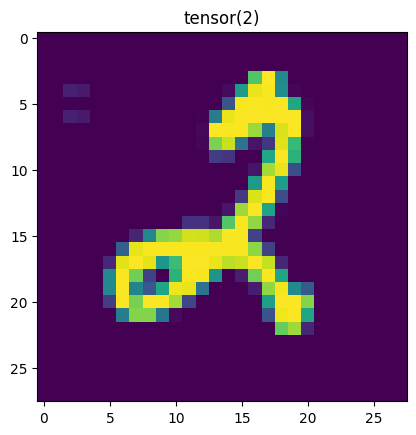

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torchvision.transforms import  ToTensor, Normalize
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

# Other code
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

testing_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

train_dataloader = DataLoader(
    training_data, batch_size = 1000,shuffle=True
)
test_dataloader = DataLoader(
    testing_data, batch_size = 1000,shuffle=True
)


train_features,train_labels = next(iter(train_dataloader))
eg_image = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(eg_image)
plt.title(label)
plt.show()

In [18]:
## Diffusion Process

In [21]:
class DiffusionU_NET(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(DiffusionU_NET,self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2)
        )

    self.bottleneck = nn.Sequential(
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
    )

    self.decoder = nn.Sequential(
        nn.Conv2d(in_channels=256,out_channels=128,kernel_size=2,stride=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64,out_channels=out_channels,kernel_size=1),
        )

  def forward(self,x):
    encoder_def = self.encoder(x)
    bottleneck = self.bottleneck(encoder_def)
    decoder_def = self.decoder(bottleneck)
    return decoder_def
# The noising part
def forward_diffusion(alphas_cumprod, x_start, t, noise):
    batch_size, _, height, width = x_start.size()
    # Expand alphas_cumprod[t] to match the shape of x_start and noise
    alphas_cumprod_t = alphas_cumprod[t].view(batch_size, 1, 1, 1).expand(batch_size, 1, height, width).to(x_start.device)
    return torch.sqrt(alphas_cumprod_t) * x_start + torch.sqrt(1 - alphas_cumprod_t) * noise


## Training Loop

In [26]:
def get_alphas_cumprod(T):
    betas = np.linspace(1e-4, 0.02, T)
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas)
    return alphas_cumprod

def train_model(train_loader,epoch_counts=30,lr=1e-3,weights_save_path = "./weights"):
  T = 1000  # Number of diffusion steps
  alphas_cumprod = get_alphas_cumprod(T)
  alphas_cumprod = torch.tensor(alphas_cumprod).float()
  model = DiffusionU_NET(in_channels=1,out_channels=1)

  optimizer = optim.Adam(model.parameters(), lr=lr)
  loss_criterion = nn.MSELoss()
# Generate alpha values to noise on each timestep
  model.train()
  for epoch in range(epoch_counts):
    epoch_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
      data = data.view(-1,1,28,28) # Reshape and
      t = torch.randint(0,T,(data.size(0),),dtype=torch.long)
      noise = torch.randn_like(data)
      x_t = forward_diffusion(alphas_cumprod,data,t,noise)

      optimizer.zero_grad()
      predicted_noise = model(x_t)
      print(f"Predicted size {predicted_noise.size()}")
      print(f"Original image size {data.size()}")
      loss = loss_criterion(predicted_noise, noise)
      loss.backward()
      # Update model weights
      optimizer.step()

      epoch_loss += loss.item()

  print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader.dataset):.4f}')

  # Save weights
  torch.save(model.state_dict(),weights_save_path)

train_model(train_dataloader)

Predicted size torch.Size([1000, 1, 7, 7])
Original image size torch.Size([1000, 1, 28, 28])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1000, 1, 28, 28])) that is different to the input size (torch.Size([1000, 1, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (7) must match the size of tensor b (28) at non-singleton dimension 3

In [ ]:
# Loading Model Weights
def load_model(model, load_path='model_weights.pth'):
    model.load_state_dict(torch.load(load_path))
    model.eval()
    print(f'Model weights loaded from {load_path}')

# Load the model weights
load_model(model)

# Sampling New Images
def sample(model, num_samples=64):
    model.eval()
    with torch.no_grad():
        x = torch.randn(num_samples, 1, 28, 28)  # Start with random noise
        for t in reversed(range(T)):
            predicted_noise = model(x)
            x = (x - predicted_noise) / np.sqrt(get_alphas_cumprod()[t])
    return x.cpu()

# Generate new images
generated_images = sample(model)

# Plot the generated images
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()